# Stock Market Prediction And Forecasting Using Stacked LSTM

In [0]:
### Data Collection from tiingo
import pandas_datareader as pdr

df = pdr.get_data_tiingo('AAPL', api_key=key)

df.to_csv('AAPL.csv')

In [0]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('AAPL.csv')
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [4]:
df.shape

(1258, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1258 non-null   int64  
 1   symbol       1258 non-null   object 
 2   date         1258 non-null   object 
 3   close        1258 non-null   float64
 4   high         1258 non-null   float64
 5   low          1258 non-null   float64
 6   open         1258 non-null   float64
 7   volume       1258 non-null   int64  
 8   adjClose     1258 non-null   float64
 9   adjHigh      1258 non-null   float64
 10  adjLow       1258 non-null   float64
 11  adjOpen      1258 non-null   float64
 12  adjVolume    1258 non-null   int64  
 13  divCash      1258 non-null   float64
 14  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 147.5+ KB


In [0]:
df1 = df.reset_index()['close']

In [8]:
df1.shape

(1258,)

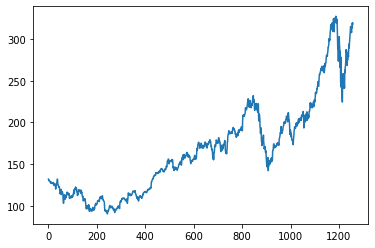

In [9]:
# importing visualization library
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data, so we apply MinMax scaler

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1.shape

(1258, 1)

In [0]:
## Splitting dataset into train and test 
# here the data in series formet so we need to divide in diffrent way
training_size= int(len(df1)*0.65) # 65% of totel length of data is train size
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [0]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]  ### i=0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i+ time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [0]:
# reshape into X=t,t+1,t+2,t+3  and Y= t+4
time_step= 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(716, 100, 1)
(716,)
(340, 100, 1)
(340,)


In [0]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [40]:
X_train.shape

(716, 100, 1)

In [0]:
# Create a LSTM model'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

In [0]:
### Lets do the prediction and checks performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [0]:
### Transfor back to original  from
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

### Claculate RMSE performance metrics

In [60]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

143.01001467792568

### Test Demo RMSE

In [61]:
math.sqrt(mean_squared_error(y_test,test_predict))

242.71641117918182

### Plotting

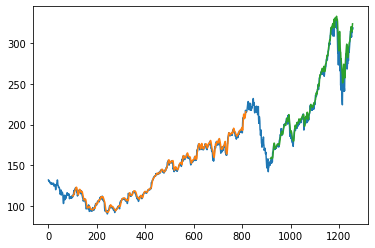

In [62]:
 # shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Green color is actual data,
orange color is training data and
green color is test data